In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import warnings
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu


warnings.filterwarnings('ignore')

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts.array[major_class_name] / target_counts.array[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df.loc[df[target_name] == target_counts.index[minor_class_name]].sample(target_counts.array[minor_class_name] )
        df = df.append(sample)#, ignore_index=True)

    return df.sample(frac=1) 

def prn_report(y_train_valid, y_train_pred, y_test_valid, y_test_pred):
    print('TRAIN:\n', classification_report(y_train_valid, y_train_pred))
    print('TEST:\n', classification_report(y_test_valid, y_test_pred))
    print('CONFUSION MATRIX:\n', pd.crosstab(y_test_valid, y_test_pred))

def evaluate_predict(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    prn_report(y_train, y_train_pred, y_test, y_test_pred)

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()    
    
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()   
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
##############################################################
def imputer_rfr(data, target_col):
    data = data.copy()
    features = data.columns
    data = data[features]
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]
    
    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        shuffle=True, 
        random_state=21
    )
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, verbouse=1)
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f'train r2_score: {r2_score(y_train, pred_train)}')
    print(f'test r2_score: {r2_score(y_test, pred_test)}')

    pred = model.predict(predict_data.drop(columns=target_col))
    data.loc[ data[target_col].isna(), target_col] = list(pred)
    return model, data

# заменит выбросы на nan можно use квантиль
def preprocess_outlier(df, col, treshhold):
    df.loc[df[col]> trshhold, col] = np.nan
    return df
##############################################################
    
    
    
def print_null_value_counts(col_nm):
    print( f"miss_count: \t{df[col_nm].isnull().sum()} ")
    print( '--------------------\nValues\t  count\n--------------------')
    print( f"{df[col_nm].value_counts()}")

# Заполнение пропусков столбца с числовыми значениями в интервале 25...75% квантиль
def fill_miss_numeric_values(df, col_nm, q_lo=0.25, q_hi=0.75 ):
    low_lim = df[col_nm].quantile(q=q_lo)
    hi_lim = df[col_nm].quantile(q=q_hi)
    n_size = df[col_nm].isnull().sum()
    r_data = np.random.randint( low=low_lim, high=hi_lim, size=n_size ).astype(np.float64)
    miss_data = pd.DataFrame( data = r_data, index = df.loc[df[col_nm].isnull(), col_nm].index, columns = [col_nm,] ) 
    df.loc[df[col_nm].isnull(), col_nm] = miss_data    

# Заполнение пропусков столбца категории, ходовыми значениями по частоте
# df - DataFrame , col_nm - str_column_name, cat_cnt - number 
def fill_miss_category_values(df, col_nm, cat_count=None):
    if cat_count is not None:
        assert cat_count <= len(df[col_nm].value_counts())
    else:
       cat_count = len(df[col_nm].value_counts()) 
    lst_vals = df[col_nm].value_counts().head(cat_count).index.tolist()
    cnt_vals = np.array(df[col_nm].value_counts().head(cat_count).values.tolist())
    cnt_vals = cnt_vals/len(df)
    add_val = (1.0-sum(cnt_vals))/cat_count
    cnt_vals += add_val
    r_data = np.random.choice(a=lst_vals, p=cnt_vals, size=df[col_nm].isnull().sum() ) 
    miss_data = pd.DataFrame( 
        data = r_data, 
        index = df.loc[df[col_nm].isnull(), col_nm].index,
        columns = [col_nm,]
    ) 
    df.loc[df[col_nm].isnull(), col_nm] = miss_data    


In c:\users\smitin\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\smitin\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\smitin\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\users\smitin\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be remove

In [2]:
import re

class DataPipeline:
    """Подготовка исходных данных"""
    def __init__(self):
        """Параметры класса"""
        self.prog = re.compile(r"(\b\d{1,2})")

    def _rule(self, str):
        fs = int(self.prog.search(str).group(0))
        if fs >8:
            return 3
        elif fs>5:
            return 2
        elif fs >2:
            return 1
        return 0   
    
    def prepare_dataset(self, df):
        """Подготовит датасет к работе к созданию модели"""
        df_rdy = df.copy()

        # Объединим два значения в одно Иметь ипотеку и ипотека на жилье 
        df_rdy.loc[df_rdy['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        # Home Ownership - домовладение
        df_rdy['Feature_INT Home Ownership'] = df_rdy['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1', 'Own Home':'2'}).astype(int)
         
        #Annual Income - Годовой доход имеется занчительное число пропусков Missing (%)	20.8%
        col_nm = 'Annual Income'
        fill_miss_numeric_values( df_rdy, col_nm )        
        
        # Years in current job Missing	371 Missing (%)	4.9%
        col_nm = 'Years in current job'
        fill_miss_category_values(df_rdy, col_nm, cat_count=5)
        df_rdy['Feature_INT Years in current job'] = df_rdy.apply(lambda x: self._rule(x[col_nm]), axis =  1)
        
        # Налоговые залоги Tax Liens 0- 7  причем 95% - 0 максимум 7 наверное можно сделать несколько градаций 
        # отработать выбросы и перевести в int
        col_nm = 'Tax Liens'
        df_rdy.loc[df_rdy[col_nm] > 3.0, col_nm] = 3.0
        df_rdy[col_nm].astype(int)
        
        # Maximum Open Credit Максимальный открытый кредит отрезать выбросы
        col_nm = 'Maximum Open Credit'
        col_nm_feature = ''.join( ('Feature_BOOL_',col_nm) )
        df_rdy[col_nm_feature] = 0
        df_rdy[col_nm_feature] = np.where( df_rdy[col_nm] > df_rdy[col_nm].quantile(q=0.95), 1, 0 )
        df_rdy.loc[df_rdy[col_nm] > df_rdy[col_nm].quantile(q=0.95), col_nm] = df_rdy[col_nm].quantile(q=0.98)
        
        # Number of Credit Problems - Количество проблем с кредитованием 0-1-2-3 и более
        col_nm = 'Number of Credit Problems'# создаем новый столбец есть или нет выброс...
        col_nm_feature = ''.join( ('Feature_BOOL_',col_nm) )
        df_rdy[col_nm_feature] = 0
        df_rdy[col_nm_feature] = np.where( df_rdy[col_nm] > 4.0, 1, 0 )
        df_rdy.loc[df_rdy[col_nm] > 4.0, col_nm] = 4.0
        df_rdy[col_nm].astype(np.uint8)

        # Months since last delinquent Missing	4081 Missing (%)	54.4%
        # Credit Score - кредитный рейтинг Missing	1557 Missing (%)	20.8%
        df_rdy = df_rdy.drop(columns=['Months since last delinquent', 'Credit Score'])
        
        # Bankruptcies Банкротства 0 - 1 - 2 и более 
        col_nm = 'Bankruptcies'
        fill_miss_category_values(df_rdy, col_nm)
        
        # Current Loan Amount Текущая сумма кредита  99999999	870	11.6% 
        # выборос меняем на популярные значен чем его заменить?
        # создаем новый столбец есть или нет выброс...
        col_nm = 'Current Loan Amount'
        lst_vals = df_rdy[col_nm].value_counts().index.tolist()
        replace_val = lst_vals[0]
        # создаем новый столбец есть или нет выброс...
        col_nm_feature = ''.join( ('Feature_BOOL_',col_nm) )
        df_rdy[col_nm_feature] = 0
        df_rdy[col_nm_feature] = np.where( df_rdy[col_nm]==replace_val, 1, 0 )

        lst_vals = lst_vals[1:]
        cnt_vals = np.array(df_rdy[col_nm].value_counts().values.tolist())
        sz = cnt_vals[0]
        cnt_vals = cnt_vals[1:]
        cnt_vals = cnt_vals/len(df_rdy)
        add_val = (1.0-sum(cnt_vals))/len(lst_vals)
        cnt_vals += add_val
        r_data = np.random.choice(a=lst_vals, p=cnt_vals, size=sz ) 
        miss_data = pd.DataFrame( 
            data = r_data, 
            index = df_rdy.loc[df_rdy[col_nm]==replace_val, col_nm].index,
            columns = [col_nm,]
        ) 
        df_rdy.loc[df_rdy[col_nm]==replace_val, col_nm] = miss_data        
        
        # Term тип кредита 
        df_rdy['Feature_BOOL_Term'] = df_rdy['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)
        # Purpose 
        #df = pd.concat([df, pd.get_dummies(df['Purpose'], prefix='Purpose')], axis=1)
        Purpose_lst = df_rdy['Purpose'].value_counts().index.tolist()
        Purpose_dict = {}
        for i, item in enumerate(Purpose_lst):
            Purpose_dict[item] = i
        df_rdy['Feature_INT Purpose'] = df_rdy['Purpose'].map(Purpose_dict).astype(int)
        # удаляем строковые данные
        object_list = df_rdy.select_dtypes(include=['object']).columns.tolist()
        
        df_rdy = df_rdy.drop(columns=object_list)
        return df_rdy
            
#     def fit(self, df):
#         """Сохранение статистик"""
#         # <your code>
        
#     def transform(self, df):
#         """Трансформация данных"""
#         # <your code>

In [3]:
# Пути к директориям и файлам
# input_train
INP_TRAIN_DATASET_PATH = 'train.csv'
# input_test
INP_TEST_DATASET_PATH = 'test.csv'
# output
TRAIN_PREP_DATASET_PATH = 'train_prep.csv'
TEST_PREP_DATASET_PATH = 'test_prep.csv'

PREP_DATASET_PATH = 'sample_submission.csv'

In [4]:
pipe_line = DataPipeline()

df = pd.read_csv(INP_TRAIN_DATASET_PATH)

df_rdy = pipe_line.prepare_dataset(df)

features_lst = df_rdy.columns.tolist()


In [21]:
X = df_rdy.copy()
X = X.drop(columns='Credit Default')
y = df_rdy['Credit Default'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    shuffle=True, 
    random_state=21,
    stratify=df_rdy['Credit Default']
)
X_train.shape, X_test.shape

((5250, 17), (2250, 17))

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier(random_state=1,
                              class_weight={0:1, 1:4},
                              max_depth=6
 )

params = { 
    'max_depth':range(1,7),
    'min_samples_leaf':range(1,15),
}
grid_search = GridSearchCV(tree, params, cv=5)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight={0: 1, 1: 4},
                                              max_depth=6, random_state=1),
             param_grid={'max_depth': range(1, 7),
                         'min_samples_leaf': range(1, 15)})

In [23]:
tree = grid_search.best_estimator_
grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 7}

In [24]:
pred_proba_test = tree.predict_proba(X_test)
pred_proba_test[:5]

array([[0.6047261 , 0.3952739 ],
       [0.38553191, 0.61446809],
       [0.38973648, 0.61026352],
       [0.38973648, 0.61026352],
       [0.71428571, 0.28571429]])

In [25]:
tree.fit(X_train,y_train)
evaluate_predict(tree, X_train, X_test, y_train, y_test)

TRAIN:
               precision    recall  f1-score   support

           0       0.92      0.35      0.50      3771
           1       0.36      0.93      0.52      1479

    accuracy                           0.51      5250
   macro avg       0.64      0.64      0.51      5250
weighted avg       0.76      0.51      0.51      5250

TEST:
               precision    recall  f1-score   support

           0       0.89      0.35      0.50      1616
           1       0.35      0.89      0.50       634

    accuracy                           0.50      2250
   macro avg       0.62      0.62      0.50      2250
weighted avg       0.74      0.50      0.50      2250

CONFUSION MATRIX:
 col_0             0     1
Credit Default           
0               560  1056
1                70   564


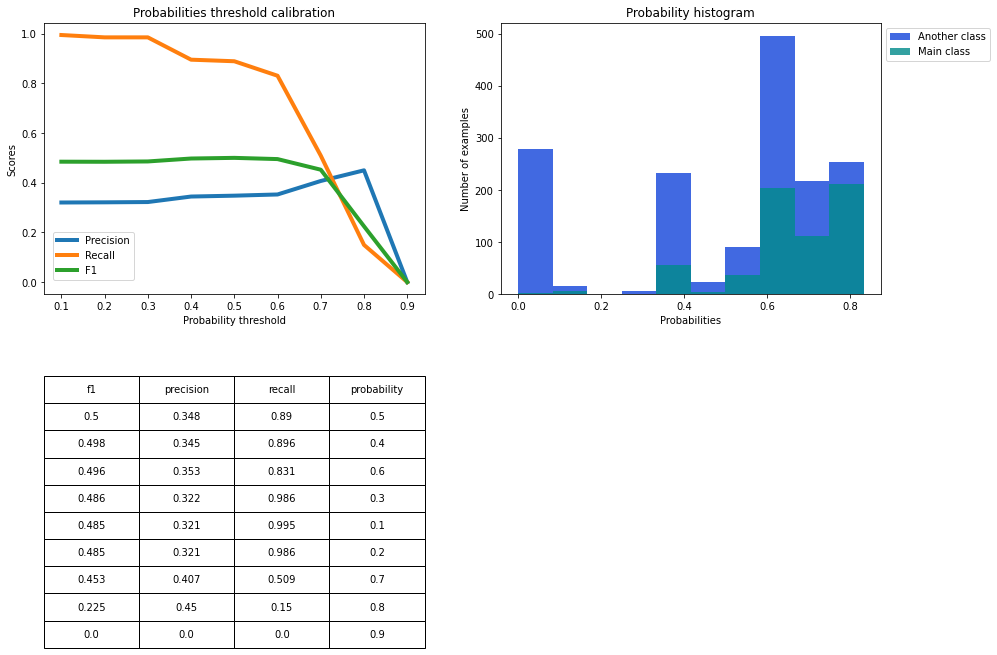

In [26]:
y_test_pred_probs = tree.predict_proba(X_test)
y_test_pred_probs[:5]

show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)